This notebook is for general exploration, foundation for other notebooks

### Useful links
[DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning](http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/)

[RDKit_Overview](http://www.rdkit.org/RDKit_Overview.pdf)

[Feature scaling](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [1]:
%run Preprocessing.ipynb

Automatically created module for IPython interactive environment


In [2]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Some of this is redundant since we already have run Preprocessing.ipynb, but it lets us look at the dataset a bit better

In [3]:
dataset_read = pd.read_excel("dataset.xlsx")
# Trim Wang's (2015) predicted values since we are calculating these ourselves
dataset = dataset_read.iloc[:,0:4]

In [4]:
# From the main dataset, split into training and test dataframes
training_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"]
test_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Te"]
print("Training set has {} items, test set has {} items".format(training_set.iloc[:,0].count(), test_set.iloc[:,0].count()))

Training set has 904 items, test set has 226 items


In [5]:
training_set.head()

,NO,Tr=traning set Te=test set,SMILES structure,experimental logD7.4
1,A-logD7.4-100,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1,-0.96
2,A-logD7.4-101,Tr,S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1,-0.92
3,A-logD7.4-104,Tr,OC=1C(=O)C=CN(CCCO)C=1C,-0.90
4,A-logD7.4-105,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)c2ccccc2C)cc1N1CCNCC1,-0.83
5,A-logD7.4-106,Tr,OC=1C(=O)C=CN(CCC(=O)NCC)C=1C,-0.82


## Fingerprinting molecules
    A way to encode and represent molecules in a format that 1) makes it easy to compare how similar or different two molecules 2) uniquely identify that molecule 3) allow for a quick and efficent search of the molecule's sub-structure.
    
    Fingerprinting is a technique traditionally used for molecule search and screening in large chemoinformatic databases, where many comparisons must be made a second. In this project, I'm hoping to use these techniques as a way to uniquely encode a molecule in a way that is easy to feed into a ML algorithm while also retaining the specific features/descriptors of that molecule which may contribute to its lipophillicity.

    Essentially a hash.

#### Quick bit on fingerprints vs structural keys
    "A fingerprint is a boolean array, or bitmap, but unlike a structural key there is no assigned meaning to each bit. Your own fingerprint is very characteristic of you, yet there is no meaning to any particular feature. Similarly, a pattern's fingerprint characterizes the pattern, but the meaning of any particular bit is not well defined... In spite of the difference between the meaning of a fingerprint's bits and a structural key's bits, fingerprints share an important feature with structural keys: If a pattern is a substructure of a molecule, every bit that is set in the pattern's fingerprint will be set in the molecule's fingerprint."
        
[Source](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)

### Which fingerprint should I use?
    Start with the RDKit fingerprint. I'll come back to see if theres a better fitting one later.
[Possible source](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)
 

## Experiment with RDKit on single molecule

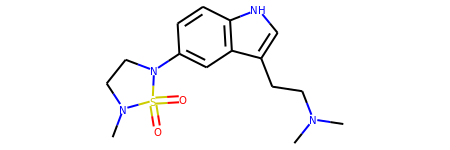

In [6]:
# taking SMILE from `training_set['SMILES structure'].iloc[1]`, creating a molecule object
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')
# Draw the molecule
molecule

### Preprocessing

In [7]:
X_train, y_train, X_test, y_test = preprocess()
in_data = {'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test}

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Testing regression models

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# Grid search
param_grid = [
  {'alpha': [1, 10, 1e-1, 1e-2, 1e-3, 1e-4],'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],'max_iter':[1,5,10,100,1000,10000], 'normalize': [True]},
]
clf = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=None, n_jobs=-1)
clf.fit(X_train, y_train)

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [1, 10, 0.1, 0.01, 0.001, 0.0001], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'max_iter': [1, 5, 10, 100, 1000, 10000], 'normalize': [True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


Linear Regression with Ridge regularizaton

r^2: 0.797
RMSE: 0.759
MSE train: 0.177
MSE test: 0.576
So, in our model, 79.709% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.76 of the real value.


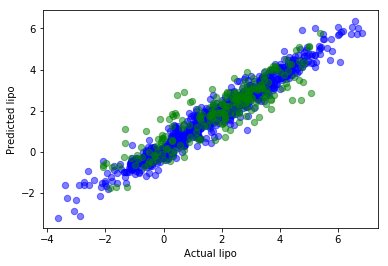

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=100, normalize=True,
   random_state=None, solver='lsqr', tol=0.001)

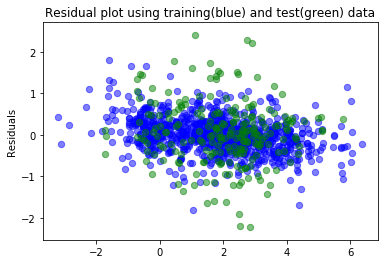

In [9]:
test_model(clf.best_estimator_, 
    "Linear Regression with Ridge regularizaton", 
    in_data,
    )

In [10]:
from sklearn.linear_model import Lasso
param_grid = [
  {'alpha': [1, 10, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],'normalize': [True], 'tol': [.01]},
]
clf = GridSearchCV(estimator=Lasso(), param_grid=param_grid)
clf.fit(X_train, y_train)

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1, 10, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'normalize': [True], 'tol': [0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


Linear Regression with Lasso regularizaton

r^2: 0.738
RMSE: 0.863
MSE train: 0.364
MSE test: 0.744
So, in our model, 73.798% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.86 of the real value.


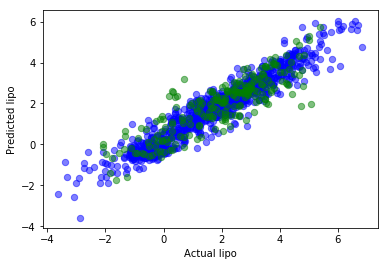

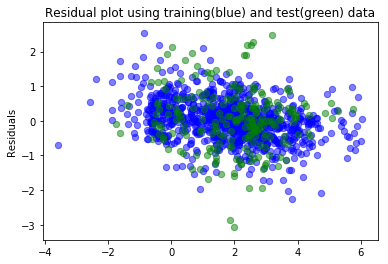

In [11]:
test_model(clf.best_estimator_, 
    "Linear Regression with Lasso regularizaton",
    in_data
    )

In [12]:
from sklearn.svm import SVR
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'degree':[2,3,4], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [1 ,1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=None, n_jobs=-1)
clf.fit(X_train, y_train)

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4], 'kernel': ['poly']}, {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


SVM Regression

r^2: 0.790
RMSE: 0.772
MSE train: 0.010
MSE test: 0.597
So, in our model, 78.996% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.77 of the real value.


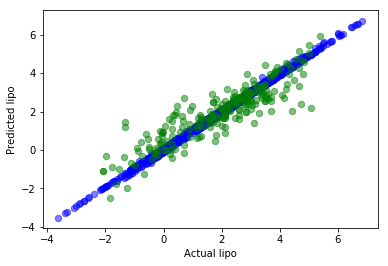

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

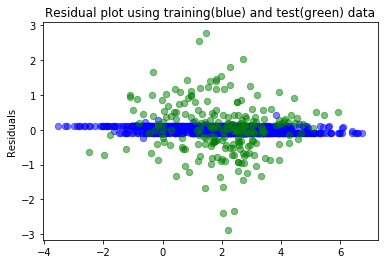

In [14]:
# C : regularization parameter, smaller values are larger margins
# Gamma : small val -> include far data points, large -> only those close to margin
svm_model = clf.best_estimator_
test_model(svm_model, "SVM Regression", in_data)